1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

Text(0.5, 0, 'x')

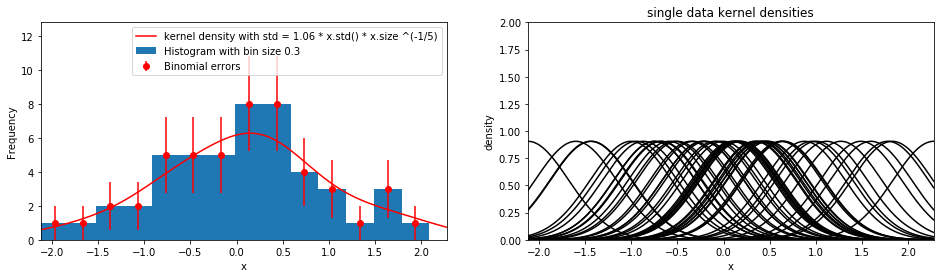

In [2]:
np.random.seed(1150407)
x = np.random.randn(50)


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
n, bins, patches = ax1.hist(x, bins = np.arange(x.min(),x.max(),0.3), density = False, label = 'Histogram with bin size 0.3')
ax1.set_ylabel('Frequency')
ax1.set_xlabel('x')
ax1.set_xlim(left=x.min(), right=x.max())
ax1.set_ylim(bottom=0, top= n.max()*8/5)
ax2.set_xlim(left=x.min(), right= x.max())
ax2.set_ylim(bottom=0, top= 2)


normalization = n.sum()*0.3


p = (bins[:-1]+bins[1:])/2
e = np.sqrt((n/300)*(1-n/300)*300)

ax1.errorbar(p, n, yerr=e, fmt='o', c ='r', label= 'Binomial errors')


np.linspace(stats.norm.ppf(0.01),stats.norm.ppf(0.99),1000)
ykern=normalization/x.size*np.array([stats.norm.pdf(y,x,1.06*x.std()*x.size**(-1/5)).sum() for y in np.linspace(x.min(),x.max(),1000)])
xkern = np.linspace(x.min(),x.max(),1000)
ax1.plot(xkern, ykern,c='r', label = 'kernel density with std = 1.06 * x.std() * x.size ^(-1/5)')

for i in range(x.size):
    ykerni = np.array([stats.norm.pdf(y,x[i],1.06*x.std()*x.size**(-1/5)) for y in np.linspace(x.min(),x.max(),1000)])
    xkerni = np.linspace(x.min(),x.max(),1000)
    ax2.plot(xkerni, ykerni,c='black')

ax2.set_title('single data kernel densities')

ax1.legend(loc = 'best')

ax2.set_ylabel('density')
ax2.set_xlabel('x')

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

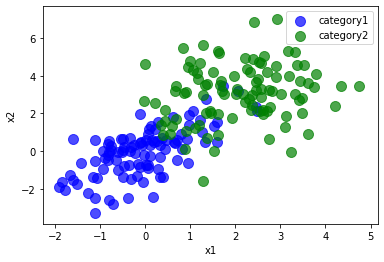

In [3]:
mean1, cov1 = [0, 0], [(1, .99999), (.99999, 2)]
data1 = np.random.multivariate_normal(mean1, cov1, 100)

mean2, cov2 = [2, 3], [(1.1, .0), (.0, 2.2)]
data2 = np.random.multivariate_normal(mean2, cov2, 100)

pd1 = pd.DataFrame(data1, index = np.arange(1,101), columns = ['x1','x2'])
pd1['category'] = 'category1'

pd2 = pd.DataFrame(data2, index = np.arange(1,101), columns = ['x1','x2'])
pd2['category'] = 'category2'

fig, ax1 = plt.subplots(figsize=(6, 4))

pdef = pd1.append(pd2)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

for i in range(np.unique(pdef['category'].values).size):
    pdplot = pdef[pdef['category'] == np.unique(pdef['category'].values)[i]]
    pdplot.plot(kind = 'scatter',x = 'x1', y='x2', ax = ax1, s = 100, c = colors[i], alpha = 0.7, label = pdplot['category'][1])

In [ ]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

Text(0, 0.5, 'residuals')

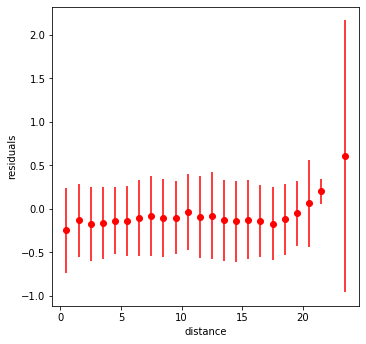

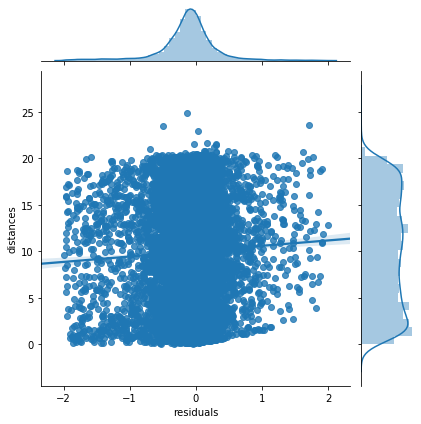

In [106]:
dr = pd.DataFrame(np.load('residuals_261.npy',allow_pickle=True).item())

fig, ax1 = plt.subplots(figsize=(5.5, 5.5))

import seaborn as sns

dr = dr[np.absolute(dr['residuals'])<2]
a,b = stats.linregress(dr).intercept, stats.linregress(dr).slope

y = np.array([dr[(bins[i] < dr['distances']) * (dr['distances'] < bins[i+1])].residuals.mean() for i in range(bins.size - 1)])

sns.jointplot(x = 'residuals', y = 'distances', data=dr, kind="reg")

distdata = dr['distances'].values
distdata

bins = np.arange(distdata.min(),distdata.max(),1)

x = (bins[:-1]+bins[1:])/2
y = np.array([dr[(bins[i] < dr['distances']) * (dr['distances'] < bins[i+1])].residuals.mean() for i in range(bins.size - 1)])
err = np.array([dr[(bins[i] < dr['distances']) * (dr['distances'] < bins[i+1])].residuals.std() for i in range(bins.size - 1)])

ax1.errorbar(x, y, yerr=err, fmt='o', c ='r')
ax1.set_xlabel('distance')
ax1.set_ylabel('residuals')